## Imports

In [152]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [176]:
# create dataframe of ranked pairs from ESM contact matrix
def df_from_esm_contact_matrix(contact_matrix):
    
    gather = []
    
    # traverse over upper right triangle, exlucding main diagonal
    for i in range(contact_matrix.shape[0]):
        for j in range(contact_matrix.shape[1]): # i+1,
            # SANITY check the matrix should be symmetric
            assert contact_matrix[i][j] == contact_matrix[j][i]
            row_dict = dict(
                i = i,
                j = j,
                prob = contact_matrix[i,j]
            )
            
            gather.append(row_dict)

    return pd.DataFrame(gather).sort_values(by='prob', ascending = False)
def heatmap_data_creator(df):
    dim = max(df["i"].max() + 1, df["j"].max() + 1)
    data = np.zeros([dim] * 2)
    for i in range(df.shape[0]):
        data[df['i'][i],df['j'][i]] = df['prob'][i]
        data[df['j'][i],df['i'][i]] = df['prob'][i]
    return dim, data

def heatmap_creator(dfs):
    if type(dfs) == list:
        dim, datas = 0, []
        for df in dfs:
            new_dim, data = heatmap_data_creator(df)
            if new_dim > dim:
                dim = new_dim
        data = np.zeros([dim] * 2)
        for d in datas:
            data += np.pad(d, ((0, dim - d.shape[0]), (0, dim - d.shape[1])))
            
    else:
        _, data = heatmap_data_creator(dfs)
    plt.imshow(data) 
    
    plt.title("2-D Heat Map") 
    plt.show()
    return data

## Load data

### Load ESM data

In [154]:
esm_results_path = os.path.join('..', 'results/cadherin/esmfold/results.zip')
esm_results = np.load(esm_results_path)
job_name = 'cadherin'

#number of sequences in Cadherin MSA
num_seqs = 55
#esm_results.keys()
esm_dfs = []
for i in range(num_seqs):
    # index into NPzFile object with file name
    contact_matrix = esm_results[f'{i}_{job_name}']
    df = df_from_esm_contact_matrix(contact_matrix)
    esm_dfs.append(df)
    
for i in range(len(esm_dfs)):
    esm_dfs[i] = df.sort_values(by="prob", ascending=False).reset_index(drop=True)

### Load True Contacts

In [163]:
real_contacts_path = os.path.join('..', 'data', 'cadherin', 'PF00028_real_contacts.csv')
real_contacts = np.genfromtxt(real_contacts_path,delimiter=',') # import
real_contacts_df = pd.DataFrame(real_contacts).astype(int)
for i in [0,1]:
    real_contacts_df["i" if i==1 else "j"] = real_contacts_df[i].astype(int) # convert to ints
real_contacts_df["prob"] = 1 # rename columns
real_contacts_df = real_contacts_df[["i", "j", "prob"]] # take only reformatted, renamed columns


### Load DCA data

In [156]:
# Load Motherfuckin DCA results 
mfdca_results_path = os.path.join('..', 'data', 'cadherin', 'PF00028_mfdca.csv')
mfdca_results = np.genfromtxt(mfdca_results_path,delimiter=',') # import
mfdca_df = pd.DataFrame(mfdca_results).iloc[1:,1:] # drop empty columns and header row
for i in [1,2]:
    mfdca_df["i" if i==1 else "j"] = mfdca_df[i].astype(int) # convert to ints
mfdca_df["prob"] = mfdca_df[3] # rename columns
mfdca_df = mfdca_df[["i", "j", "prob"]] # take only reformatted, renamed columns
mfdca_df = mfdca_df.sort_values(by="prob", ascending=False).reset_index(drop=True) # sort by descending score and reset index
# Load PLM DCA results TODO: CURRENTLY A STAND-IN
plmdca_results_path = os.path.join('..', 'data', 'cadherin', 'PF00028_mfdca.csv')
plmdca_results = np.genfromtxt(mfdca_results_path,delimiter=',')
plmdca_df = pd.DataFrame(plmdca_results).iloc[1:,1:]
for i in [1,2]:
    plmdca_df["i" if i==1 else "j"] = plmdca_df[i].astype(int) # convert to ints
plmdca_df["prob"] = plmdca_df[3] # rename columns
plmdca_df = plmdca_df[["i", "j", "prob"]] # take only reformatted, renamed columns
plmdca_df = plmdca_df.sort_values(by="prob", ascending=False).reset_index(drop=True) # sort by descending score and reset index

## Process Data

In [157]:
# replace with whatever L (length of true structure file protein) should actually be
# for the precision@L calculations

# NOTE: these indices are relative to the sequence, not MSA
# NOTE: only include unique pairs if i,j exists then j,i does not and i != j
L = 90
top_L_esm = esm_dfs[0][:L]
top_L_mf = mfdca_df[:L]
top_L_plm = plmdca_df[:L]
real_contacts_df

,0,1,j,i,prob
0,12,7,12,7,1
1,16,8,16,8,1
2,16,9,16,9,1
3,16,10,16,10,1
4,16,11,16,11,1
...,...,...,...,...,...
1624,212,119,212,119,1
1625,212,120,212,120,1
1626,212,179,212,179,1
1627,212,180,212,180,1


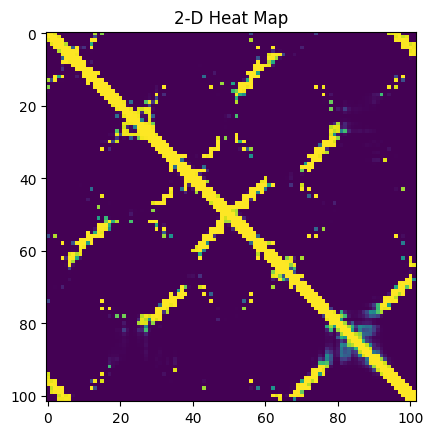

In [158]:
heatmap_creator(esm_dfs[0])

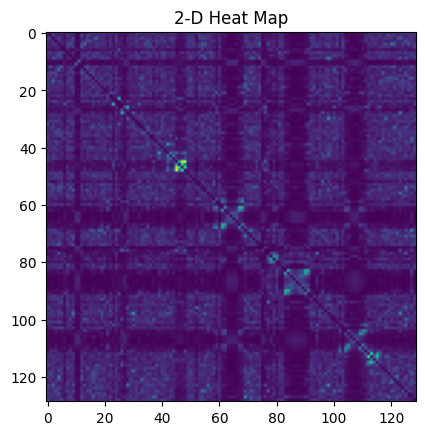

In [159]:
heatmap_creator(mfdca_df)

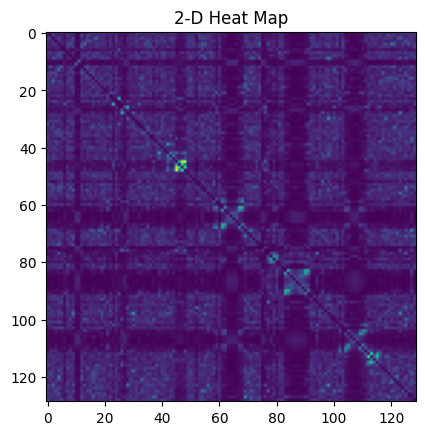

In [160]:
heatmap_creator(plmdca_df)

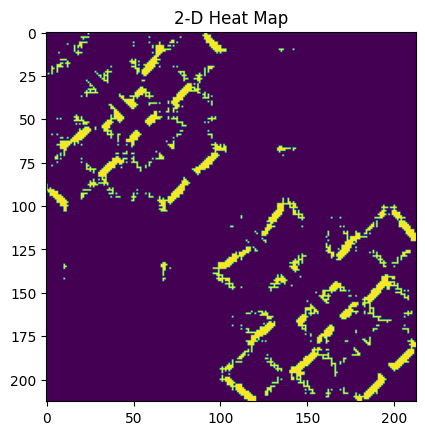

In [179]:
d=heatmap_creator(real_contacts_df)

In [178]:
d.max()

0.0